# DallE2: Change Image Background using DallE2 and Azure Computer Vision.

#### Overview:   
In general, many companies spend a significant amount of money each year on photography. However, by leveraging the capabilities of OpenAI, DallE2, and Florence to process images, a wide range of powerful features can be generated from a single image. These features include the ability to create detailed captions, extract color information, generate advertising campaigns based on the image, and even use DallE2 to replace the image's background with a new one derived from the extracted colors and caption information.

### Notebook Organization
-Import Packages and credentials  
-Remove background  
-Extract colors  
-Extract Dense Caption  
-Generate DallE2 prompt  
-Create DallE2 Image  
-Compose 2 images  

## install packages

In [ ]:
!pip install requests
!pip install Pillow
!pip install openai
!pip install azure-cognitiveservices-vision-computervision
!pip install python-dotenv
!pip install azure-storage-blob
!pip install futures
!pip install python-dotenv
!pip install webcolors

## import packages & credential

In [8]:
import requests
import json
from PIL import Image
import openai
import os
import random
import requests
import os
import azure.ai.vision as visionsdk
import time
from collections import defaultdict
import io
import concurrent.futures
from dotenv import load_dotenv  
import logging
from azure.storage.blob import BlobServiceClient, ContentSettings
from io import BytesIO
import string 
import json
from openai import cli
import concurrent.futures
import math
import webcolors
import tempfile

load_dotenv()
connect_str = os.environ.get('connect_str')
container_name = os.environ.get('container_name')
openai.api_type = 'azure'
openai.api_base = os.environ.get('openai.api_base')
openai.api_version = os.environ.get('openai.api_version')
openai.api_key = os.environ.get('openai.api_key')
vision_background_base= os.environ.get('cognitive_background_endpoint')
vision_base= os.environ.get('cognitive_endpoint')
vision_key= os.environ.get('cognitive_key')

# Original Image

In [5]:
from IPython.display import Image

# Replace "image_url" with the actual URL of the image you want to display
image_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/125818161/1800"

# Display the image
Image(url=image_url)

## Remove background  

#### By utilizing Azure Florence's background removal feature, it is possible to obtain a binary image that contains only the removed background data.

In [2]:
def background_removal(image_url):
  url = vision_background_base
  image = image_url

  payload = json.dumps({
    "url": image
  })
  headers = {
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': vision_key
  }

  response = requests.request("POST", url, headers=headers, data=payload)
  removal = response.content
  # Save the response content to a file

  removal = response.content
  return removal


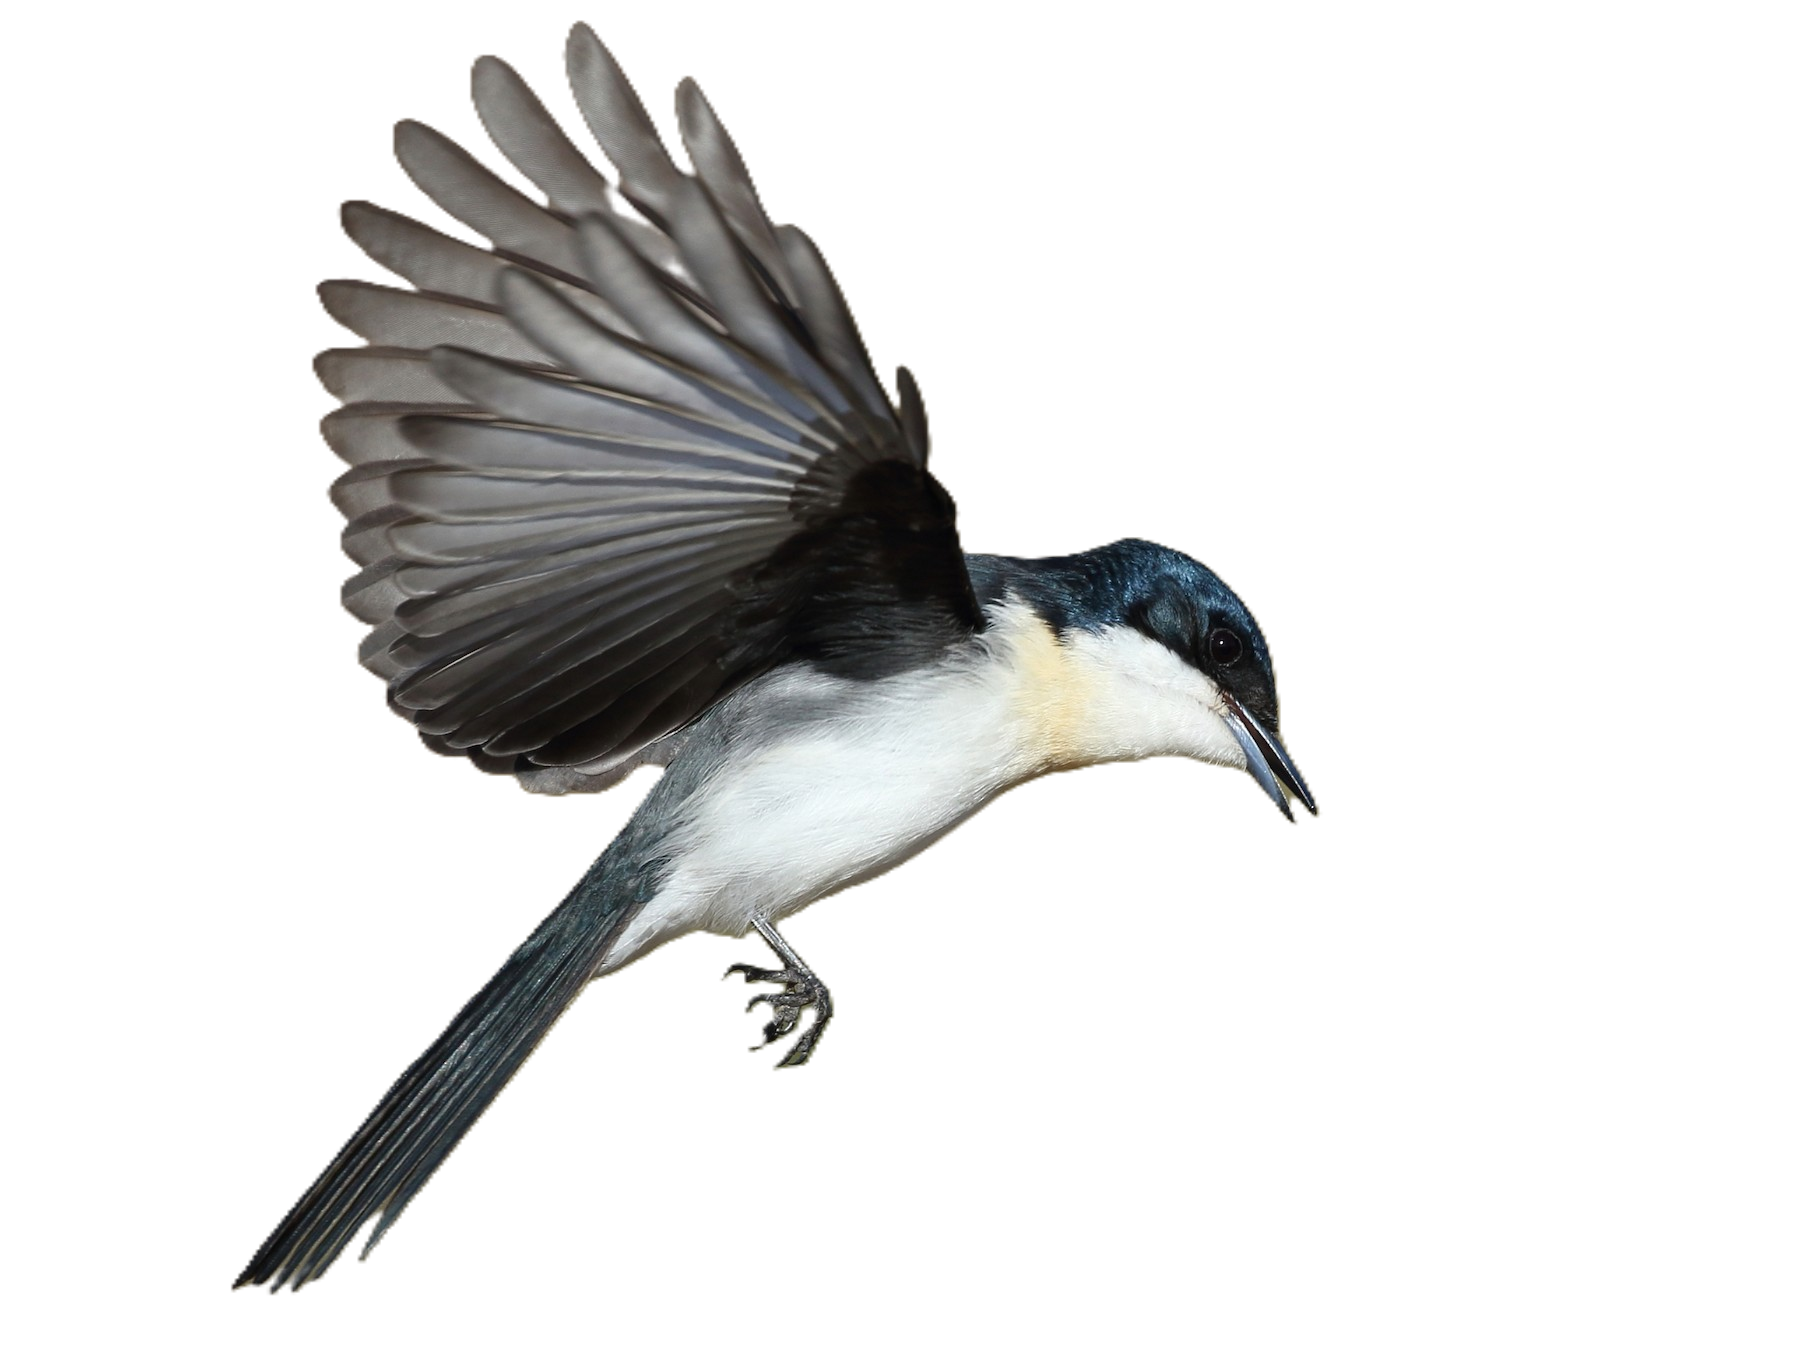

In [3]:
image_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/125818161/1800"

removal=background_removal(image_url)

# Create a PIL Image object from the image data
img = Image.open(BytesIO(removal))

display(img)


## Create DallE2 Image  


#### Due to DallE2 being in the preview stage, it's prone to instability, and therefore, we need to introduce a retry feature. While DallE2 does offer a Retry-After feature that we can use, we need to exercise caution with it. I recommend adding an additional gap of one second after the Retry-After time to improve the chances of success, as it often fails without this additional time.

In [21]:
def get_image(prompt):
    api_version = '2022-08-03-preview'
    url = "{}dalle/text-to-image?api-version={}".format(openai.api_base, api_version)
    headers = {"api-key": openai.api_key, "Content-Type": "application/json"}
    body = {
        "caption": prompt,
        "resolution": "1024x1024"
    }

    max_tries = 8
    tries = 0
    total_wait = 30
    time_waited = 0

    while tries < max_tries and time_waited < total_wait:
        submission = requests.post(url, headers=headers, json=body)
        if submission.status_code != 202:
            retry_after = int(submission.headers.get('Retry-After', 0))
            time.sleep(retry_after+2)
            logging.info("failed: DallE2 Request failed. retry")
            print("failed: DallE2 Request failed. retry")
            continue
        else:
            try:
                operation_location = submission.headers['Operation-Location']
            except KeyError:
                logging.info("failed: Operation-Location header missing!!!")
                print("failed: Operation-Location header missing!!!")
                time.sleep(1)
                continue
            
            start_time = time.time()
            while time.time() - start_time < total_wait - time_waited:
                response = requests.get(operation_location, headers=headers)
                if response.status_code == 200:
                    status = response.json()['status']
                    if status == "Succeeded":
                        logging.info("succeeded...")
                        print("succeeded...")
                        return response.json()['result']['contentUrl']
                    elif status == "Running":
                        retry_after = int(response.headers.get('Retry-After', 0))
                        time.sleep(retry_after)
                    else:
                        logging.info("failed: status = " + status)
                        print("failed: status = " + status)
                        break
                else:
                    logging.info("failed: response code = " + str(response.status_code))
                    print("failed: response code = " + str(response.status_code))
                    time.sleep(1)
                    break
                time_waited = time.time() - start_time
                tries += 1
            if status == "Succeeded":
                break
            else:
                tries += 1
    return None

failed: status = NotStarted
succeeded...


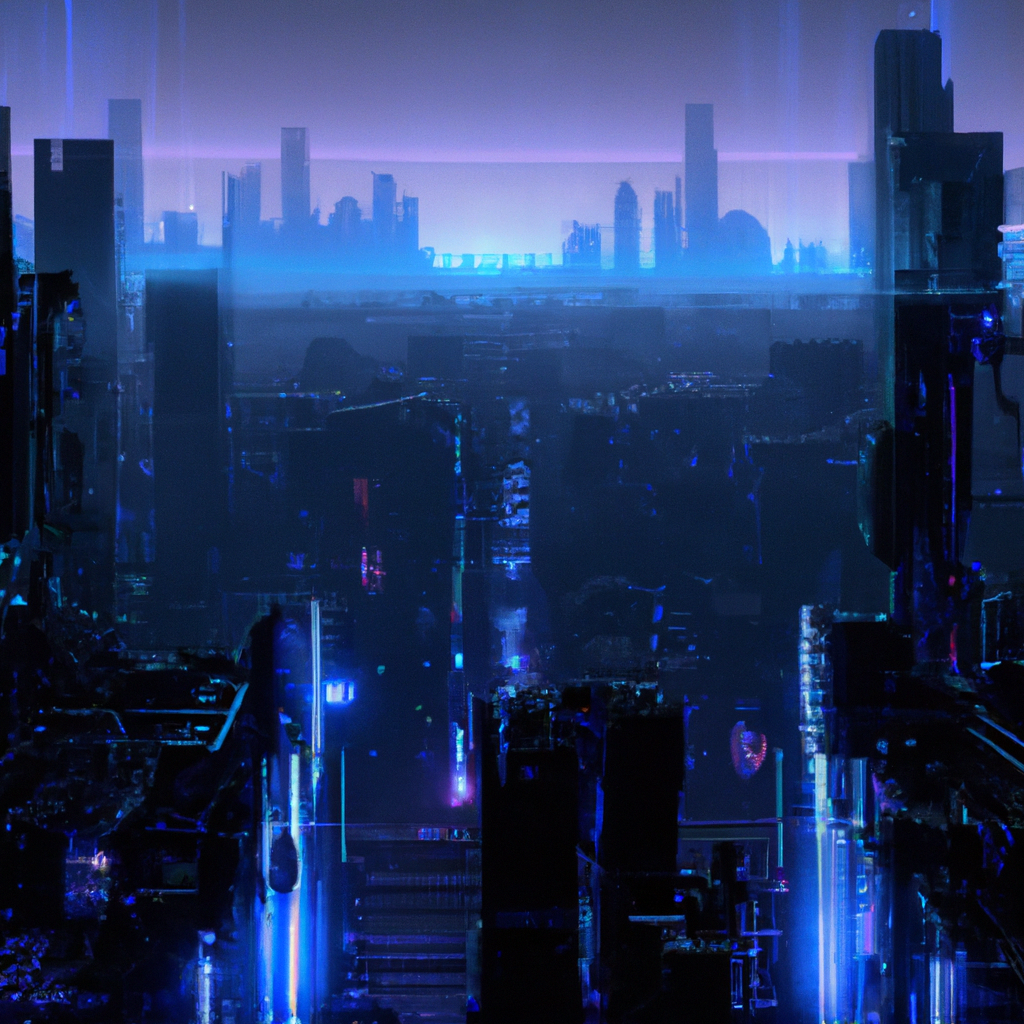

In [28]:
prompt = "a metropolitan city, Cyberpunk, Long shot"
result= get_image(prompt)
response = requests.get(result)

# Load the image data from the response content
img_data = response.content

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

display(img)


## Compose 2 images  

#### With the help of the Pillow library's Image module, it is possible to merge two images together. These images would typically consist of a background-removed image and a background image generated by DallE2.

In [23]:
def compose_image(removal, result, size):

    image_file = io.BytesIO(removal)
    front_img = Image.open(image_file)

    response = requests.get(result)
    back_img = Image.open(BytesIO(response.content))

    # Resize the front image while maintaining its aspect ratio
    front_img.thumbnail((size,size))

    # Find the size of the larger image
    width = max(front_img.width, back_img.width)
    height = max(front_img.height, back_img.height)

    # Create a new empty image with the size of the larger image
    composed_img = Image.new("RGBA", (width, height))

    # Paste the back image onto the composed image with an offset
    back_offset = ((width - back_img.width) // 2, (height - back_img.height) // 2)
    composed_img.paste(back_img, back_offset)

    # Paste the front image onto the composed image with an offset
    front_offset = ((width - front_img.width) // 2, (height - front_img.height) // 2)
    composed_img.paste(front_img, front_offset, front_img)

    return composed_img

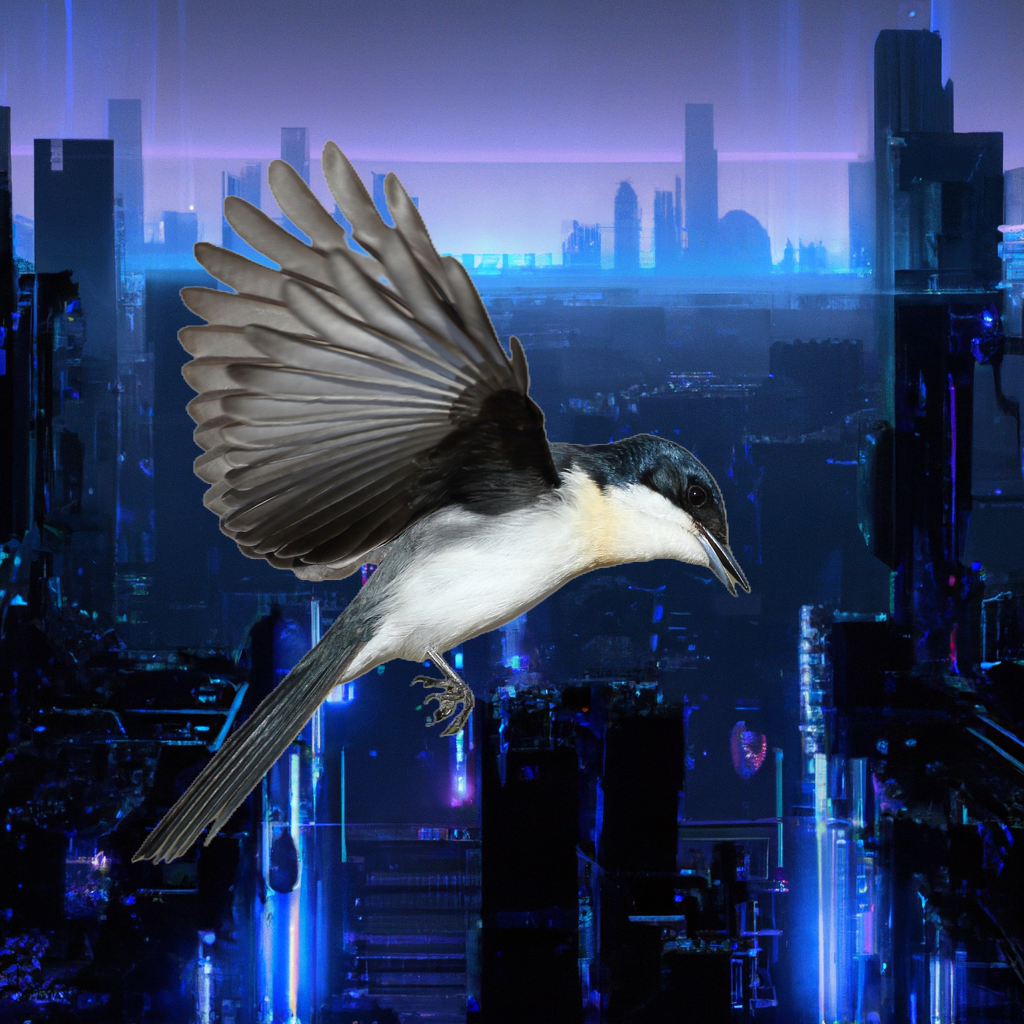

In [29]:
size = 1024
composed_img= compose_image(removal, result, size)
display(composed_img)